# Simulation of Velocity Profiling

In [1]:
# Imports
import contracts
contracts.disable_all()
import duckietown_uplan as uplan
import duckietown_world as dw
import numpy as np
from duckietown_uplan.algo.velocity_profiler import VelocityProfiler
np.random.seed(3)

INFO:dt-uplan:duckietown_uplan 1.0.0
INFO:dt-world:duckietown-world 1.0.19
DEBUG:dt-serialization:Registering class Serializable
DEBUG:dt-serialization:Registering class GenericData
DEBUG:dt-serialization:Registering class Sequence
DEBUG:dt-serialization:Registering class SampledSequence
DEBUG:dt-serialization:Registering class Constant
DEBUG:dt-serialization:Registering class RectangularArea
DEBUG:dt-serialization:Registering class TransformSequence
DEBUG:dt-serialization:Registering class VariableTransformSequence
DEBUG:dt-serialization:Registering class SE2Transform
DEBUG:dt-serialization:Registering class Scale2D
DEBUG:dt-serialization:Registering class Matrix2D
DEBUG:dt-serialization:Registering class SpatialRelation
DEBUG:dt-serialization:Registering class GroundTruth
DEBUG:dt-serialization:Registering class PlacedObject
DEBUG:dt-serialization:Registering class EvaluatedMetric
DEBUG:dt-serialization:Registering class GenericObject
DEBUG:dt-serialization:Registering class Duckie
D

First of all lets load a map

In [2]:
current_map = dw.load_map('4way')

INFO:dt-world:loading map 4way


To start the simulation of the duckietown lets instantiate the simulation with one duckiebot (It takes a while!)

In [3]:
simulation_exp = uplan.ConstantProbabiltiySim(current_map, 1)

Now that we initialized the simulation we can run it for one second and extract the path 

In [4]:
simulation_exp.execute_simulation(1)
path = simulation_exp.duckie_town.duckie_citizens[0].get_path()

Started move function
distance to travel:  0.25
distance to next control point is :  0.0
reached a control point here
reached a control point here


To plan a velocity trajectory using the path retrieved from the simulation we need to have a list of uncertainties of an obstacle being in the path:

* 1 means that we are certain that an obstacle is in a certain point in the path
* 0 means that we are completely certain that there is no obstacle

Lets simulate this as sine function (We can freely modify this function):

In [5]:
def gen_uncertainties(num):
    f = lambda x: 1/2 - 1/2*np.cos(x)
    #f = lambda x: x**2
    t = np.linspace(0, 4*np.pi, num)
    #t = np.linspace(0, 1, num)
    uncertainties = [f(x) for x in t]
    return uncertainties

uncertainties = gen_uncertainties(len(path))

## Cost Function

For the planning algorithm to know how to plan for a good velocity profile we use a cost functions that includes the following terms:

* **[delta_v_norm]** Changes in velocity from node to node
* **[delta_unc]** The difference in uncertainty from node to node
* **[unc]** The uncertainty level
* **[next_vel_norm]** The next velocity normalized (v - v_min)/(v_max-v_min)
* **[error_norm]** Error from reference to actual speed (normalized) (reference is taken as max_v, this makes us go as fast as possible given that there is no uncertainty)

The current implemented cost function is:

$$cost = a1*delta_v_norm^2 + a3*unc + a5*error_norm$$

Of course the cost function is customizable and can be change with a few lines of code, if no cost function is sent to Velocity profiler then it is going to use the above mentioned.


In [6]:
def cost_function(delta_v_norm=0, delta_unc=0, unc=0, next_vel_norm=0, error_norm=0):
    a1 = 3
    a2 = 0
    a3 = 4
    a4 = 0
    a5 = 0.1
    
    sum_of_terms = a1*delta_v_norm**2 + a2*delta_unc + a3*unc**2 + \
        a4*next_vel_norm**2 + a5*error_norm**2
    return sum_of_terms

# Takes min velocity, max velocity, num
vel_prof = VelocityProfiler(10, 100, 10)
traj = vel_prof.get_velocity_profile(50, path, uncertainties, cost_function)

As last step we instantiate Velocity Profiler and we set a start velocity

In [7]:
# Takes min velocity, max velocity, num
min_vel = 10
max_vel = 100
num = 10
start_vel = 50

vel_prof = VelocityProfiler(min_vel, max_vel, num)
traj = vel_prof.get_velocity_profile(start_vel, path, uncertainties, cost_function)

## Plot of results

Text(0, 0.5, 'Probability')

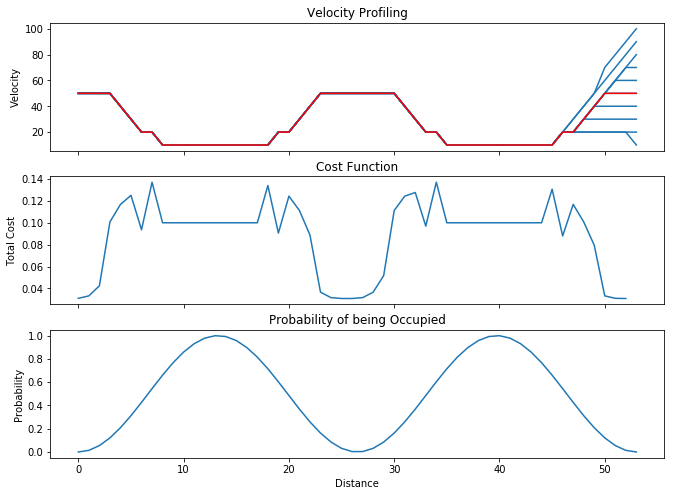

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

f, axarr = plt.subplots(3, sharex=True, figsize=(11, 8))
for cost, vels in vel_prof.trajectory_history:
    axarr[0].plot(vels, c='C0')
axarr[0].plot(traj, c='r')
axarr[0].set_title('Velocity Profiling')
axarr[0].set_ylabel("Velocity")
axarr[1].plot(vel_prof.cost_array, c="C0")
axarr[1].set_title('Cost Function')
axarr[1].set_ylabel("Total Cost")
axarr[2].plot(uncertainties, c="C0")
axarr[2].set_title('Probability of being Occupied')
axarr[2].set_xlabel("Distance")
axarr[2].set_ylabel("Probability")